In [1]:
import numpy as np

# Define a signal function that generates random values based on a function
def signal_function(x):
    min_val, max_val = np.sin(x) + x * np.sin(x), 20
        # Define circular region parameters
    center_x, center_y = 0, 10  # Center coordinates
    radius = 3  # Radius
    y_test = np.random.uniform(low=min_val, high=max_val, size=(1,))
    if (np.isnan(y_test)):
        print(y_test)
    # Check if the point (x, y) is outside the circular region
    if (x - center_x)**2 + (y_test - center_y)**2 > radius**2:
        return y_test
    else:
        return np.random.uniform(low=15, high=20, size=(1,))

# Define a background function that generates random values based on a function
def background_function(x):
    min_val, max_val = np.sin(x) + x * np.sin(x), 20
        # Define circular region parameters
    center_x, center_y = 0, 10  # Center coordinates
    radius = 4  # Radius
    y_test = np.random.uniform(low=min_val, high=max_val, size=(1,))
    if (x - center_x)**2 + (y_test - center_y)**2 < radius**2:
        return y_test
    else:
        min_val, max_val = -20, np.sin(x) + x * np.sin(x)  
        y_test = np.random.uniform(low=min_val, high=max_val, size=(1,))
        return y_test

# Generate synthetic data for signal and background
data_size = 3000

# Generate signal data
signal_x = np.random.uniform(low=-11.0, high=10.0, size=(data_size,))
signal_y = np.zeros(data_size, dtype=float)
signal_label = np.ones(data_size)
for count, x in enumerate(signal_x):
    signal_y[count] = signal_function(x)
signal_data = np.column_stack((signal_x, signal_y, signal_label))

# Generate background data
background_x = np.random.uniform(low=-11.0, high=10.0, size=(data_size,))
background_y = np.zeros(data_size, dtype=float)
background_label = np.zeros(data_size)
for count, x in enumerate(background_x):
    background_y[count] = background_function(x)
background_data = np.column_stack((background_x, background_y, background_label))

/var/folders/h1/s46zdkz905j6q1vd7vxjj6v40000gn/T/ipykernel_73143/1601934543.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  signal_y[count] = signal_function(x)
/var/folders/h1/s46zdkz905j6q1vd7vxjj6v40000gn/T/ipykernel_73143/1601934543.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  background_y[count] = background_function(x)


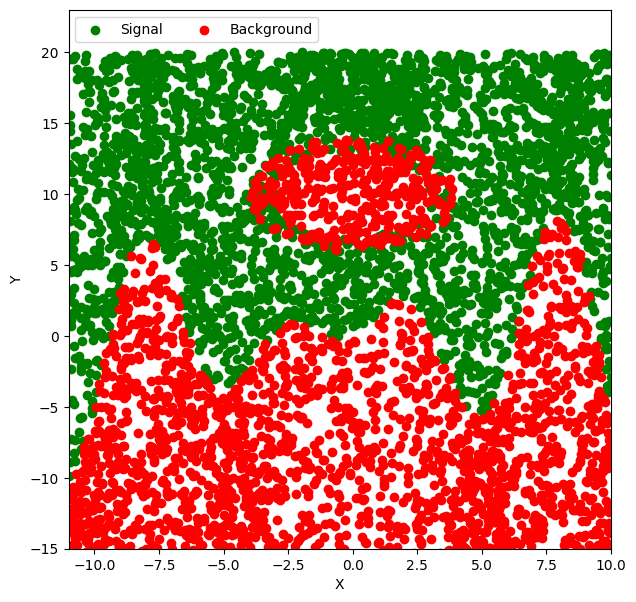

In [2]:
import matplotlib.pyplot as plt

# Plot the actual data points along with the actual function and estimated line
plt.figure(1, figsize=(7, 7))
plt.scatter(signal_data[:, 0], signal_data[:, 1], color='green', label="Signal")
plt.scatter(background_data[:, 0], background_data[:, 1], color='red', label="Background")
plt.legend(loc="upper left", ncol=4)
plt.xlim(-11, 10)
plt.ylim(-15, 23)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

signal_label = np.ones(len(signal_data))
signal_data = np.column_stack((signal_data, signal_label))

background_label = np.zeros(len(background_data))
background_data = np.column_stack((background_data, background_label))

# Concatenate signal and background data
full_data = np.vstack((signal_data, background_data))

# Shuffle the data
np.random.shuffle(full_data)

# Split data into features (X) and labels (y)
X = full_data[:, :2]  # Features (x, y)
y = full_data[:, 2]   # Labels (1 for signal, 0 for background)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# default: max_depth=2, min_samples_split=2
DTC = DecisionTreeClassifier(max_depth=3,min_samples_split=10)
BDT = AdaBoostClassifier(estimator=DTC,n_estimators=100,algorithm = 'SAMME')

# Train the BDT! One line, very fast
# actually time here?
model = BDT.fit(X_train, y_train) # BDT looks at each feature independently, so scaling is typically not necessary

# Make predictions on the test set using 'predict' instead of 'decision_function'
y_pred_test = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 96.25%
Confusion Matrix:
[[595  22]
 [ 23 560]]


Text(0.5, 0, 'BDT output')

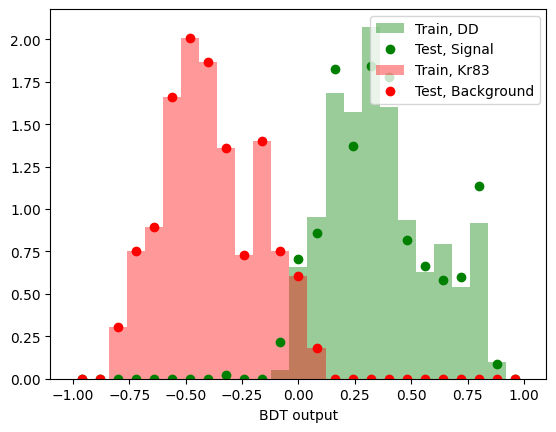

In [4]:
# What do the decision function outputs look like for signal vs background?
y_pred_signal_train = model.decision_function(X_train[y_train==1])
y_pred_signal_test = model.decision_function(X_test[y_test==1])
y_pred_background_train = model.decision_function(X_train[y_train==0])
y_pred_background_train = model.decision_function(X_test[y_test==0])

n_bins=25
hist_range=(-1.0,1.0)
plt.hist(y_pred_signal_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color='green',label="Train, DD")
counts,bin_edges = np.histogram(y_pred_signal_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color='green',label="Test, Signal")

plt.hist(y_pred_background_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color='red',label="Train, Kr83")
counts,bin_edges = np.histogram(y_pred_background_train,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color='red',label="Test, Background")

plt.legend()
plt.xlabel('BDT output')

Text(0.5, 0, 'X')

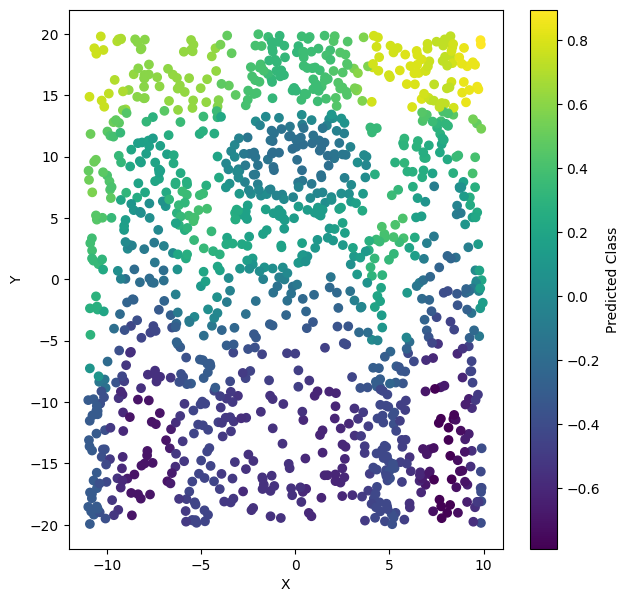

In [5]:
plt.figure(figsize=(7,7))
y_pred_test = model.decision_function(X_test)
scatter = plt.scatter(X_test[:,0],X_test[:,1],c=y_pred_test, cmap='viridis')
plt.colorbar(scatter, label='Predicted Class')
plt.ylabel('Y')
plt.xlabel('X')

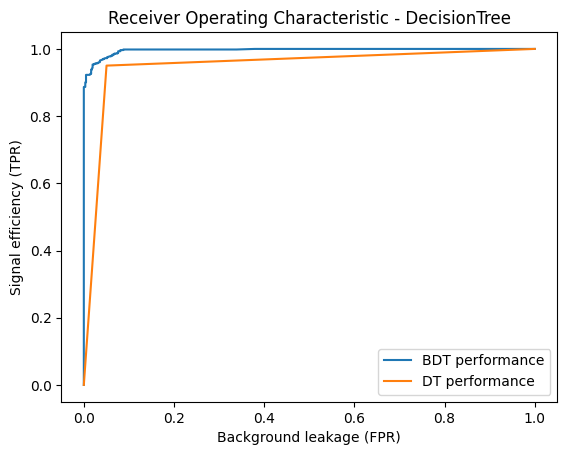

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
# Assuming it's a binary classification problem, calculate ROC-AUC score
DT_FPR = [0., 0.05033557, 1.] 
DT_TPR = [0., 0.95033113, 1.]
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y_test, y_pred_test, pos_label=1) # Signal class set to 1
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")
plt.plot(DT_FPR, DT_TPR, label="DT performance")
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')
plt.legend(loc="lower right")
plt.show()



[Text(0.5769230769230769, 0.875, 'x[1] <= 13.722\ngini = 0.461\nsamples = 4800\nvalue = [0.639, 0.361]'),
 Text(0.3076923076923077, 0.625, 'x[1] <= -5.769\ngini = 0.4\nsamples = 3807\nvalue = [0.638, 0.244]'),
 Text(0.15384615384615385, 0.375, 'x[0] <= -10.429\ngini = 0.064\nsamples = 1543\nvalue = [0.181, 0.006]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.498\nsamples = 66\nvalue = [0.007, 0.006]'),
 Text(0.23076923076923078, 0.125, 'gini = -0.0\nsamples = 1477\nvalue = [0.175, 0.0]'),
 Text(0.46153846153846156, 0.375, 'x[1] <= -0.402\ngini = 0.45\nsamples = 2264\nvalue = [0.457, 0.238]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.454\nsamples = 481\nvalue = [0.044, 0.083]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.397\nsamples = 1783\nvalue = [0.412, 0.155]'),
 Text(0.8461538461538461, 0.625, 'x[1] <= 13.797\ngini = 0.015\nsamples = 993\nvalue = [0.001, 0.117]'),
 Text(0.7692307692307693, 0.375, 'x[1] <= 13.796\ngini = 0.453\nsamples = 15\nvalue = [0.001, 0.002]'),
 Text(0.69

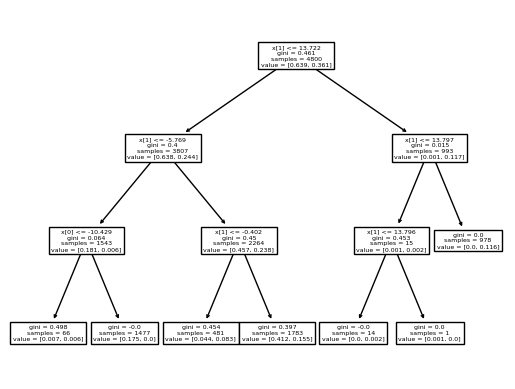

In [7]:
from sklearn import tree
DT_0 = model.estimators_[1]
tree.plot_tree(DT_0)